# Segmenting remote sensing imagery with box prompts

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/box_prompts.ipynb)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/box_prompts.ipynb)

This notebook shows how to generate object masks from box prompts with the Segment Anything Model (SAM).

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [ ]:
!uv venv
!source .venv/bin/activate
!uv pip install --system segment-geospatial groundingdino-py leafmap localtileserver

Streaming output truncated to the last 5000 lines.
   Building sam2==1.1.0
      Built groundingdino-py==0.4.0
      Built iopath==0.1.10
      Built antlr4-python3-runtime==4.9.3
⠹ Preparing packages... (49/54)
nvidia-cusparse-cu12 ------------------------------ 126.75 MiB/197.84 MiB
nvidia-cufft-cu12 ------------------------------ 127.45 MiB/201.66 MiB
nvidia-cublas-cu12 ------------------------------ 126.63 MiB/346.60 MiB
   Building sam2==1.1.0
      Built groundingdino-py==0.4.0
      Built iopath==0.1.10
      Built antlr4-python3-runtime==4.9.3
⠹ Preparing packages... (49/54)
nvidia-cusparse-cu12 ------------------------------ 126.75 MiB/197.84 MiB
nvidia-cufft-cu12 ------------------------------ 127.54 MiB/201.66 MiB
nvidia-cublas-cu12 ------------------------------ 127.18 MiB/346.60 MiB
   Building sam2==1.1.0
      Built groundingdino-py==0.4.0
      Built iopath==0.1.10
      Built antlr4-python3-runtime==4.9.3
⠸ Preparing packages... (49/54)
nvidia-cusparse-cu12 -----------

In [ ]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo import SamGeo

## Create an interactive map

In [ ]:
m = leafmap.Map(center=[-22.17615, -51.253043], zoom=18, height="800px")
m.add_basemap("SATELLITE")
m

## Download a sample image

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [ ]:
bbox = m.user_roi_bounds()
if bbox is None:
    bbox = [-51.2565, -22.1777, -51.2512, -22.175]

In [ ]:
image = "Image.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

Downloaded image 01/45
Downloaded image 02/45
Downloaded image 03/45
Downloaded image 04/45
Downloaded image 05/45
Downloaded image 06/45
Downloaded image 07/45
Downloaded image 08/45
Downloaded image 09/45
Downloaded image 10/45
Downloaded image 11/45
Downloaded image 12/45
Downloaded image 13/45
Downloaded image 14/45
Downloaded image 15/45
Downloaded image 16/45
Downloaded image 17/45
Downloaded image 18/45
Downloaded image 19/45
Downloaded image 20/45
Downloaded image 21/45
Downloaded image 22/45
Downloaded image 23/45
Downloaded image 24/45
Downloaded image 25/45
Downloaded image 26/45
Downloaded image 27/45
Downloaded image 28/45
Downloaded image 29/45
Downloaded image 30/45
Downloaded image 31/45
Downloaded image 32/45
Downloaded image 33/45
Downloaded image 34/45
Downloaded image 35/45
Downloaded image 36/45
Downloaded image 37/45
Downloaded image 38/45
Downloaded image 39/45
Downloaded image 40/45
Downloaded image 41/45
Downloaded image 42/45
Downloaded image 43/45
Downloaded 

In [ ]:
##image = "2.tif"
image="tile_1024_grid_00_16.tif"
#tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

You can also use your own image. Uncomment and run the following cell to use your own image.

In [ ]:
# image = '/path/to/your/own/image.tif'

Display the downloaded image on the map.

In [ ]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

## Initialize SAM class

Set `automatic=False` to disable the `SamAutomaticMaskGenerator` and enable the `SamPredictor`.

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

Specify the image to segment.

In [ ]:
sam.set_image(image)

Display the map. Use the drawing tools to draw some rectangles around the features you want to extract, such as trees, buildings.

In [ ]:
m

## Create bounding boxes

If no rectangles are drawn, the default bounding boxes will be used as follows:

In [ ]:
if m.user_rois is not None:
    boxes = m.user_rois
else:
    boxes = [
        [-51.2546, -22.1771, -51.2541, -22.1767],
        [-51.2538, -22.1764, -51.2535, -22.1761],
    ]

## Segment the image

Use the `predict()` method to segment the image with specified bounding boxes. The `boxes` parameter accepts a list of bounding box coordinates in the format of [[left, bottom, right, top], [left, bottom, right, top], ...], a GeoJSON dictionary, or a file path to a GeoJSON file.

In [ ]:
sam.predict(boxes=boxes, point_crs="EPSG:25831", output="mask2.tif", dtype="uint8")

## Display the result

Add the segmented image to the map.

In [ ]:
m.add_raster("mask2.tif", cmap="viridis", nodata=0, layer_name="Mask")
m

## Use an existing vector file as box prompts

Alternatively, you can specify a file path to a vector file. Let's download a sample vector file from GitHub.

In [ ]:
url = "https://opengeos.github.io/data/sam/tree_boxes.geojson"
geojson = "tree_boxes.geojson"
leafmap.download_file(url, geojson)

Downloading...
From: https://opengeos.github.io/data/sam/tree_boxes.geojson
To: /content/tree_boxes.geojson
28.1kB [00:00, 16.2MB/s]                   


'/content/tree_boxes.geojson'

Display the vector data on the map.

In [ ]:
m = leafmap.Map()
m.add_raster("Image.tif", layer_name="image")
style = {
    "color": "#ffff00",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0,
}
m.add_vector(geojson, style=style, zoom_to_layer=True, layer_name="Bounding boxes")
m

Map(center=[-22.17635, -51.25385], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Segment image with box prompts

Segment the image using the specified file path to the vector mask.

In [ ]:
sam.predict(boxes=geojson, point_crs="EPSG:4326", output="mask2.tif", dtype="uint8")

No valid pixel coordinates found.


TypeError: 'NoneType' object is not subscriptable

Display the segmented masks on the map.

In [ ]:
m.add_raster("mask2.tif", cmap="Greens", nodata=0, opacity=0.5, layer_name="Tree masks")
m

![](https://i.imgur.com/SpA2NV9.gif)

In [ ]:
geojson='seles_mega_zona_tank.geojson'

In [ ]:
m = leafmap.Map()
m.add_raster("tile_1024_grid_03_10.tif", layer_name="image")
style = {
    "color": "#ffff00",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0,
}
m.add_vector(geojson, style=style, zoom_to_layer=True, layer_name="Bounding boxes")
m

Map(center=[41.3359985, 2.154661], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [ ]:
sam.set_image("tile_1024_grid_03_10.tif")

In [ ]:
sam.predict(boxes=geojson, point_crs="EPSG:4326", output="mask8.tif", dtype="uint8")

In [ ]:
m.add_raster("mask8.tif", cmap="Greens", nodata=0, opacity=0.5, layer_name="Tree masks")
m

Map(bottom=25077957.0, center=[41.3359985, 2.154661], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [ ]:
m.save('predict_sam_geometrize.html')

IndexError: too many indices for tensor of dimension 3

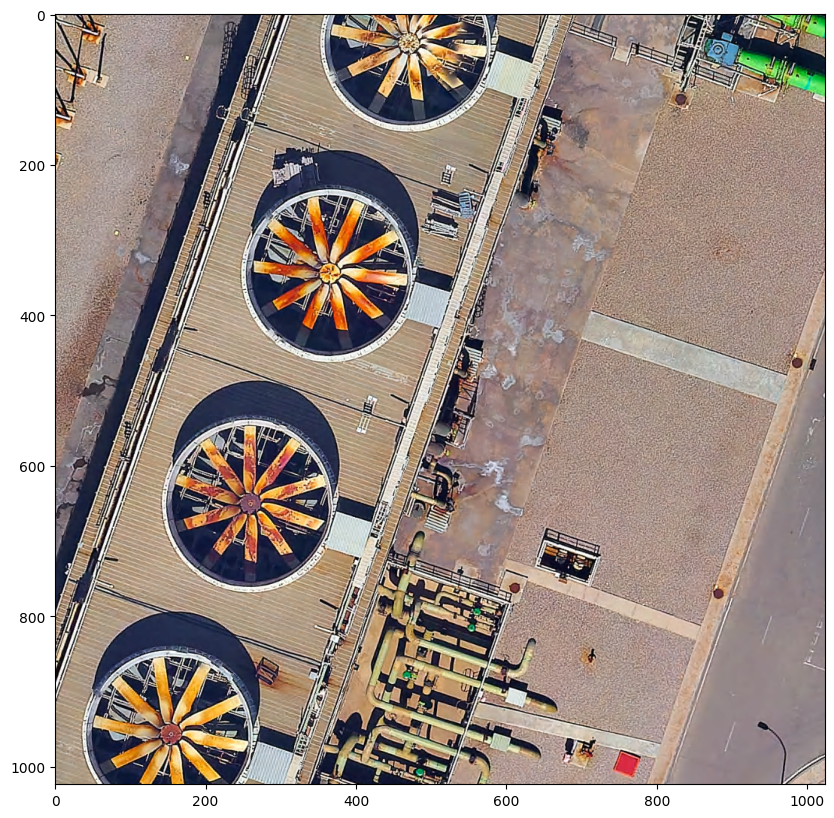

In [ ]:
sam.show_anns(
    cmap="Greens",
    box_color="red",
    title="Segmentación de tanques a partir de Bounding Box",
    blend=True,
)

In [ ]:
geojson='seles_mega_zona_tank.geojson'

In [ ]:
m = leafmap.Map()
m.add_raster("tile_1024_grid_03_10.tif", layer_name="image")
style = {
    "color": "#ffff00",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0,
}
m.add_vector(geojson, style=style, zoom_to_layer=True, layer_name="Bounding boxes")
m

In [ ]:
sam.predict(boxes=geojson, point_crs="EPSG:4326", output="mask9.tif", dtype="uint8")

In [ ]:
m.add_raster("mask9.tif", cmap="Greens", nodata=0, opacity=0.5, layer_name="Tree masks")
m